## Day 32 Lecture 1 Assignment

In this assignment, we will learn about K nearest neighbor regression. We will use the absenteeism at work dataset loaded below and analyze the model generated for this dataset.

The meaning of the different columns can be found here: https://www.kaggle.com/tonypriyanka2913/employee-absenteeism

In [1]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
absent = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv', sep=';')

In [3]:
absent.shape

(740, 21)

In [4]:
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


Find which variables have the highest pairwise correlation and remove them from our dataset. Additionally, try to think of which variables are correlated by looking at the column names and remove those columns as well.

Note: When choosing between two categorical variables that are correlated, you often want to keep the one with fewer unique values. Why might that be? (Think about the cons of KNN.)

                                 Reason for absence  Month of absence  \
Reason for absence                         1.000000         -0.083858   
Month of absence                          -0.083858          1.000000   
Day of the week                            0.116319         -0.006528   
Seasons                                   -0.117925          0.407770   
Transportation expense                    -0.119381          0.137525   
Distance from Residence to Work            0.161831         -0.003887   
Service time                               0.048425         -0.062862   
Age                                       -0.078608         -0.001520   
Work load Average/day                     -0.123472         -0.169989   
Hit target                                 0.088943         -0.460453   
Disciplinary failure                      -0.545054          0.107946   
Education                                 -0.047357         -0.066128   
Son                                       -0.055364

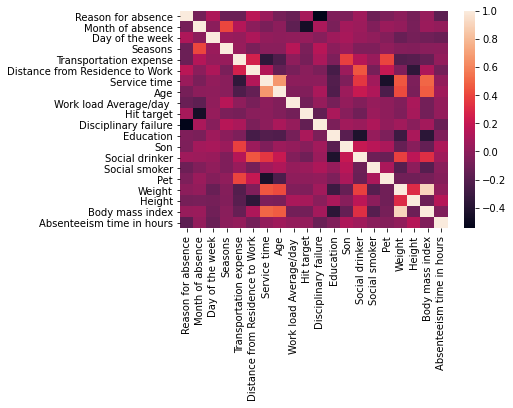

In [5]:
# answer below:
sns.heatmap(absent.drop('ID', axis=1).corr())
print(absent.drop('ID', axis=1).corr())

In [6]:
absent['Weight'].value_counts
absent['Body mass index'].value_counts

<bound method IndexOpsMixin.value_counts of 0      30
1      31
2      31
3      24
4      30
       ..
735    30
736    29
737    34
738    35
739    25
Name: Body mass index, Length: 740, dtype: int64>

In [7]:
clean = absent.drop(columns=['Body mass index', 'Service time'], axis=1)

Figure out which columns actually contain sneaky categorical variables and turn those into dummy variables.

In [49]:
# answer below:
seasons = pd.get_dummies(clean['Seasons'], drop_first=True, prefix='season')
months = pd.get_dummies(clean['Month of absence'], drop_first=True, prefix='month')
days = pd.get_dummies(clean['Day of the week'], drop_first=True, prefix='day')
excuse = pd.get_dummies(clean['Reason for absence'], drop_first=True, prefix='excuse')
education = pd.get_dummies(clean['Education'], drop_first=True, prefix='education_level')
dt = pd.concat([clean.drop(['Month of absence', 'Day of the week', 'Seasons', 'Reason for absence', 'Education'], axis=1), seasons, months, days, excuse, education], axis=1)
dt = dt.drop('ID', axis=1)


In [50]:
dt.head()

,Transportation expense,Distance from Residence to Work,Age,Work load Average/day,Hit target,Disciplinary failure,Son,Social drinker,Social smoker,Pet,...,excuse_22,excuse_23,excuse_24,excuse_25,excuse_26,excuse_27,excuse_28,education_level_2,education_level_3,education_level_4
0,289,36,33,239.554,97,0,2,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,118,13,50,239.554,97,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,179,51,38,239.554,97,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,279,5,39,239.554,97,0,2,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,289,36,33,239.554,97,0,2,1,0,1,...,0,1,0,0,0,0,0,0,0,0


Split the data into train and test with test containing 20% of the data, then scale your features.

In [51]:
# answer below:
from sklearn.model_selection import train_test_split
X = dt.drop('Absenteeism time in hours', axis=1)
y = dt['Absenteeism time in hours']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_fitted = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_fitted = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Train a series of KNN regression models with a range of K values. For each K value, use cross validation of the training set and find the average RMSE score. Make a plot of K versus average RMSE. What is the best value of K?

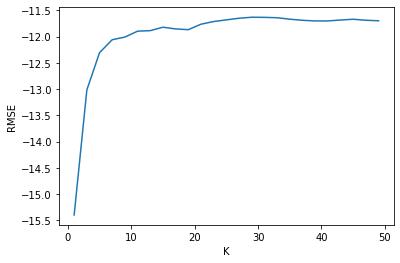

In [55]:
# answer below
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

k_list = np.arange(1, 50, 2)

cross_val_scores = {}

for k_value in k_list:
  knn = KNeighborsRegressor(n_neighbors=k_value)
  fit = knn.fit(X_train_fitted, y_train)
  scores = cross_val_score(knn, X_train_fitted, y_train, cv=5, scoring='neg_root_mean_squared_error')
  score = scores.mean()
  cross_val_scores[k_value] = score

cross_val_scores.items()
plt.plot(k_list, cross_val_scores.values())
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()


Using your best K, fit a model to all your training data and show the RMSE for the training and testing sets.

In [58]:
from sklearn.metrics import mean_squared_error
knn = KNeighborsRegressor(n_neighbors=31)
fit = knn.fit(X_train_fitted, y_train)
pred_train = fit.predict(X_train_fitted)
pred_test = fit.predict(X_test_fitted)
score_train = fit.score(X_train_fitted, y_train)
score_test = fit.score(X_test_fitted, y_test)
print('train score:', score_train)
print('test score:', score_test)

train score: 0.1531798013414477
test score: 0.09819695018914343


Create a homoscedasticity plot (also called residual plot). How is your model performing? What ideas do you have to improve the model?

In [14]:
# answer below

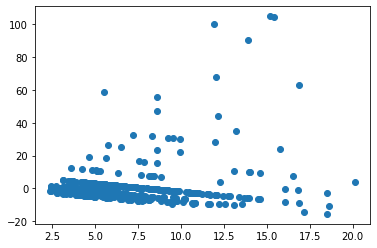

In [57]:
residual = y_train - pred_train
plt.scatter(pred_train, residual)
plt.show()

Residuals get much higher as the prediction gets higher. perhaps collecting more pertinent data or removing more variables would help